# Bootstrapping

Lucas De Oliveira, Kooha Kwon, Melvin Vellera

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import t
import random

## Quick Recap

Bootstrapping is a technique of **iterative resampling with replacement** to make inferences about the general population without conducting more experiments.

Say we ran an experiment and collected the following results:

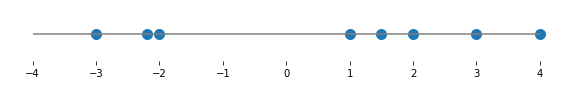

In [3]:
# Experimental sample
exp_sample = [-3, -2.2, -2, 1, 1.5, 2, 3, 4]

# Plot
fig, ax = plt.subplots(figsize=(10, 1))
ax.hlines(y=0.0, xmax=4.0, xmin=-4.0, color='grey')
ax.scatter(exp_sample, [0]*len(exp_sample), s=100)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Let's see what bootstrapped samples look like (re-run code cell to see variability of samples)...

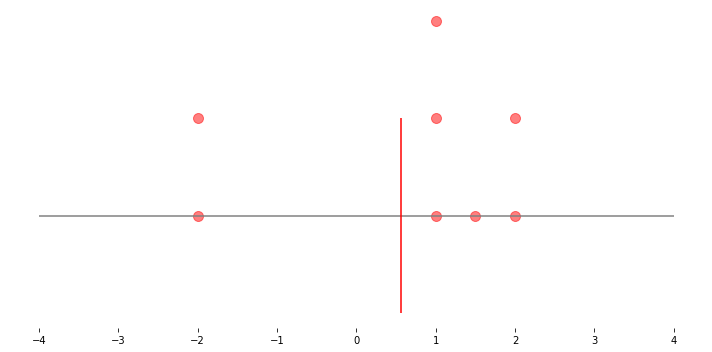

In [4]:
# Get bootstrapped sample with counts
inds = np.random.randint(0, 8, 8)
strap = [exp_sample[j] for j in inds]
val_count = Counter(strap)

bootstrap = []
counts = []
for val, count in val_count.items():
    k = 1
    while k <= count:
        bootstrap.append(val)
        counts.append(k)
        k += 1


# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.hlines(y=1.0, xmax=4.0, xmin=-4.0, color='grey')
ax.scatter(bootstrap, counts, s=100, color='red', alpha=.5)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.vlines(x=np.mean(bootstrap), ymin=0.0, ymax=2.0, color='red')

plt.tight_layout()
plt.show()

Finally, we can analyze the summary statistic(s) for our bootstrapped samples:

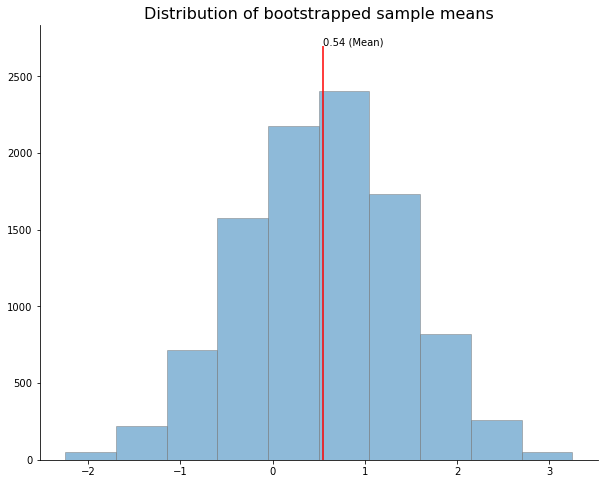

In [5]:
# Bootstrap 10,000 samples
means = []

for i in range(10_000):
    inds = np.random.randint(0, 8, 8)
    strap = [exp_sample[j] for j in inds]
    means.append(np.mean(strap))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(means, alpha=.5, edgecolor='grey')
ax.vlines(x=np.mean(means), ymin=0, ymax=2700, color='red')
ax.annotate(f'{np.mean(means):.2f} (Mean)', (np.mean(means), 2700))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Distribution of bootstrapped sample means', size=16)

plt.show()

## Real Data Example: Body Fat Percentage


In [6]:
# Load data
bfp = pd.read_csv('BodyFatPercentage.csv')
bfp.head()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1,12.6,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,2,6.9,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,3,24.6,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,4,10.9,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,5,27.8,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


### Let's Take A Look Into Population Data

In [7]:
bf_mean = bfp['BODYFAT'].mean()
pop_n = len(bfp)
print(f'Population Size: {pop_n}')

Population Size: 252


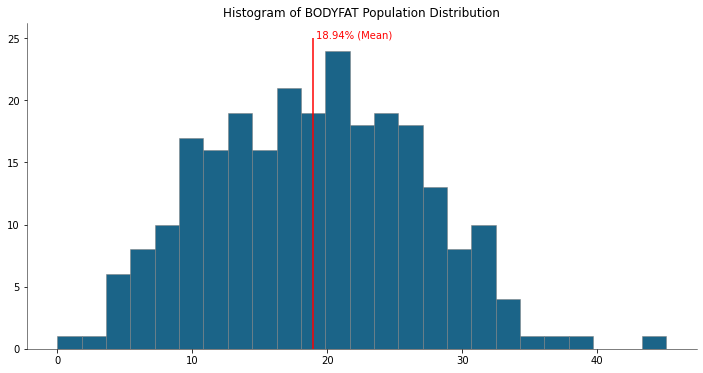

In [8]:
# Population Histogram
fig, ax = plt.subplots(figsize=(12, 6))

n, bins, patches = ax.hist(bfp['BODYFAT'], bins=25, color='#1B6488')
for rect in patches:
    rect.set_linewidth(.5)
    rect.set_edgecolor('grey')

ax.set_title('Histogram of BODYFAT Population Distribution')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

ax.vlines(x=bf_mean, ymin=0, ymax=25, color='red')
ax.annotate(f'{bf_mean:.2f}% (Mean)', (bf_mean+0.2, 25), color='r')

plt.show()

### Now, lets say that we surveyed 10 peoeple and we had to draw conclusions about the population distribution


In [9]:
# Randomly Pull 10 Rows Using Random.Sample
n = 10
sample_bfp = bfp.loc[random.sample(range(252), 10)]
sample_bfp['BODYFAT']

83     26.2
137    28.4
21     15.3
153    16.5
246    29.1
199    22.6
227    24.5
109    21.0
165    19.0
91     18.1
Name: BODYFAT, dtype: float64

### Traditional Statistical CI

In [10]:
s = np.std(sample_bfp['BODYFAT'], ddof=1)
sample_mean = sample_bfp['BODYFAT'].mean()
t_stat = t.ppf(1-0.05/2, n-1)
standard_error = (s / np.sqrt(n))

stat_ci = [sample_mean - t_stat * standard_error, sample_mean
           + t_stat * standard_error]

print(f'Population Mean:    {bf_mean:.2f}')
print(f'Sample Mean:        {sample_mean:.2f}')
print(f'Traditional 95% CI: {[f"{e:.2f}" for e in stat_ci]}')
print(f'Interval Range:     {stat_ci[1] - stat_ci[0]:.2f}')

Population Mean:    18.94
Sample Mean:        22.07
Traditional 95% CI: ['18.57', '25.57']
Interval Range:     7.01


### Bootstrapping Statistical CI

1. Resample the sample with replacement
2. Calculate and collect the resample mean
3. Repreat Steps 1 - 3
4. Build Histogram
5. Build CI using the Histogram

In [11]:
resample_means = []

for i in range(10_000):  # Step 3
    inds = np.random.randint(0, n-1, n-1)  # Step 1
    mean = sample_bfp['BODYFAT'].iloc[inds].mean()  # Step 2
    resample_means.append(mean)


boot_mean = np.mean(resample_means)
boot_ci = [np.quantile(resample_means, 0.025),
           np.quantile(resample_means, 0.975)]

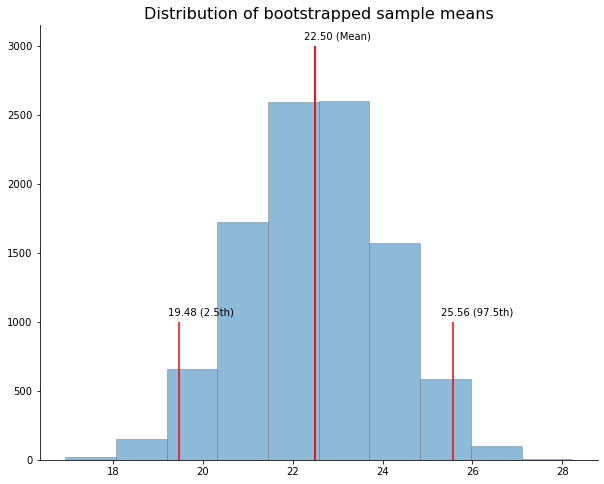

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(resample_means, alpha=0.5, edgecolor='grey')
ax.vlines(x=boot_mean, ymin=0, ymax=3000, color='red')
ax.vlines(x=boot_ci[0], ymin=0, ymax=1000, color='red')
ax.vlines(x=boot_ci[1], ymin=0, ymax=1000, color='red')
ax.vlines(x=boot_mean, ymin=0, ymax=3000, color='red')

ax.annotate(f'{boot_mean:.2f} (Mean)', (boot_mean-0.25, 3050))
ax.annotate(f'{boot_ci[0]:.2f} (2.5th)', (boot_ci[0]-0.25, 1050))
ax.annotate(f'{boot_ci[1]:.2f} (97.5th)', (boot_ci[1]-0.25, 1050))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Distribution of bootstrapped sample means', size=16)

plt.show()

In [13]:
print(f'Statistical 95% CI:        {[f"{e:.2f}" for e in stat_ci]}')
print(f'Tradtional Interval Range: {stat_ci[1]-stat_ci[0]:.2f}')

print(f'Bootstrap 95% CI:          {[f"{e:.2f}" for e in boot_ci]}')
print(f'Bootstrap Interval Range:  {boot_ci[1]-boot_ci[0]:.2f}')

Statistical 95% CI:        ['18.57', '25.57']
Tradtional Interval Range: 7.01
Bootstrap 95% CI:          ['19.48', '25.56']
Bootstrap Interval Range:  6.08


### What if you have a statistic for which you do not know the standard statistical calculation? 
Let's consider the Adj Rsquared statistic:

In [14]:
# Bootstrapping for Adj Rsquared

# Fit model for entire population and get adj rsquared
import statsmodels.formula.api as smf
model = smf.ols('BODYFAT ~ ABDOMEN + WRIST + ANKLE + AGE', data=bfp).fit()
pop_adj_rsquared = model.rsquared_adj

# Fit model for a sample of the population and get adj rsquared
samp_n = 30
sample_bfp = bfp.loc[random.sample(range(pop_n), samp_n)]
sample_model = smf.ols('BODYFAT ~ ABDOMEN + WRIST + ANKLE + AGE',
                       data=sample_bfp).fit()
samp_adj_rsquared = sample_model.rsquared_adj

print(f'Population Rsquared_adj: {pop_adj_rsquared:.2f}')
print(f'Sample Rsquared_adj: {samp_adj_rsquared:.2f}')

Population Rsquared_adj: 0.71
Sample Rsquared_adj: 0.77


In [15]:
# Do bootstrapping and get the confidence interval for this sample adj rsquared
adj_rsquareds = []
for i in range(1_000):
    inds = np.random.randint(0, samp_n-1, samp_n-1)
    model = smf.ols('BODYFAT ~ ABDOMEN + WRIST + ANKLE + AGE',
                    data=sample_bfp.iloc[inds]).fit() # Fit the model!
    rsq_adj = model.rsquared_adj
    adj_rsquareds.append(rsq_adj)

boot_rsq_adj_mean = np.mean(adj_rsquareds)
boot_rsq_adj_ci = [np.quantile(adj_rsquareds, 0.025),
                   np.quantile(adj_rsquareds, 0.975)]

print(f'Bootstrap Confidence Interval (Adj Rsquared): '
      + f'''{[f'{e:.2f}' for e in boot_rsq_adj_ci]}''')

Bootstrap Confidence Interval (Adj Rsquared): ['0.49', '0.88']


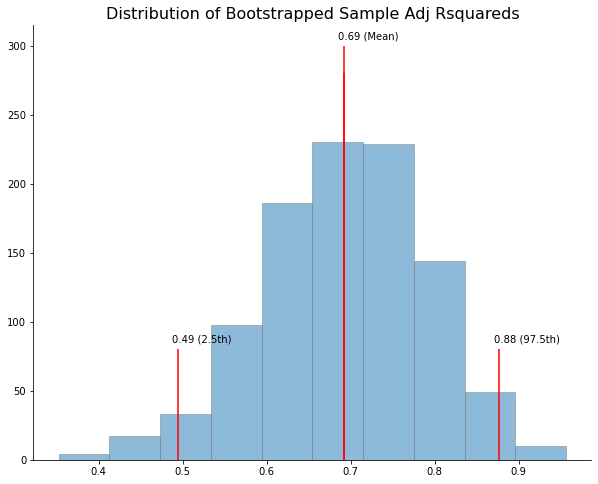

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(adj_rsquareds, alpha=.5, edgecolor='grey')
ax.vlines(x=boot_rsq_adj_mean, ymin=0, ymax=300, color='red')
ax.vlines(x=boot_rsq_adj_ci[0], ymin=0, ymax=80, color='red')
ax.vlines(x=boot_rsq_adj_ci[1], ymin=0, ymax=80, color='red')
ax.vlines(x=boot_rsq_adj_mean, ymin=0, ymax=280, color='red')

ax.annotate(f'{boot_rsq_adj_mean:.2f} (Mean)', (boot_rsq_adj_mean-0.007, 305))
ax.annotate(f'{boot_rsq_adj_ci[0]:.2f} (2.5th)',
            (boot_rsq_adj_ci[0]-0.007, 85))
ax.annotate(f'{boot_rsq_adj_ci[1]:.2f} (97.5th)',
            (boot_rsq_adj_ci[1]-0.007, 85))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Distribution of Bootstrapped Sample Adj Rsquareds', size=16)

plt.show()

### Summary
1. Bootstrapping work wells for **very small sample sizes**
2. For such small sample sizes, it can give more **precise confidence intervals** (i.e smaller intervals) as compared to standard statistical methods 
3. Boostrapping can be used for almost ANY statistic! (even for ones that do not have a **normally distributed** sampling distribution, or for ones for which statistical calculations have **not been discovered** yet!)

To conclude, when everything else fails, you can always pull yourself up by your bootstraps and start bootstrapping to get some confidence (intervals).